# 3D Brain MRI Classification Using Imaging Data Commons, Google Cloud, and NIFTI files

In this notebook, we will use the Imaging Data Commons (IDC) database and Google Cloud to demonstrate how we can pool examplary scans from IDC and use Google Cloud to do a training on that data. For the sake of this notebook, we will work on T2-weighted Brain MRIs from the TCGA_GBM and TCGA_LGG collections of IDC and train a 3D calssifier model on that data to descriminate low-grade and high-grade tumors from each other.

### Part 0 - Initial preparements!

Let's start first with installing and importing the packages we need:

In [ ]:
!pip install pylidc
!pip install nibabel
!conda install pydicom --channel conda-forge -y
!conda install -c conda-forge tensorboard -y
!pip install torchsummary
!pip install segmentation_models_pytorch
!pip install KevinSR
!pip install dicom2nifti
!pip install monai

In [13]:
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import random
import pydicom
import dicom2nifti
import pylidc as pl
from pylidc.utils import consensus
from skimage.measure import find_contours
from KevinSR import mask_interpolation
from scipy.ndimage import zoom
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import torchvision
import segmentation_models_pytorch as smp
import monai
from monai.metrics import compute_roc_auc
from monai.transforms import Activations, AddChanneld, AsDiscrete, Compose, LoadImaged, RandRotate90d, Resized, ScaleIntensityd, ToTensord, Spacingd, SpatialPadd
from tqdm import tqdm
import time

%matplotlib inline

If you are working in Google Colab, it is a good practice to have your IDC project ID determined at the beginning of your notebook and also authorize your Google account as follows (you can skip the latter if you are using Google Cloud): 

In [1]:
myProjectID = "idc-external-005"

In [ ]:
from google.colab import auth
auth.authenticate_user()

### Part 1 - Targeting the DICOM files using their metadata and BigQuery

As the first step in our project, we need to identify the appropriate DICOM files we are looking for. Thanks to IDC and Google Cloud, this is not a difficult task. IDC stores the metadata for the DICOM files it stores in a SQL table called "canceridc-data.idc_views.dicom_all" (check the IDC Documentation to read more about their datasets and tables). This metadata includes almost all the tags present in standard DICOM files, linkes to download the DICOM files, and some other useful tags like the name of the collection each DICOM belongs to. Having such a huge table may look frustrating at first, but we can use BigQuery to access and obtain whatever data we need from that table. This is super-useful as BigQuery is fast and we do not need to download the heavy DICOM files themselves to take a look at their metadata.

OK, to start let's use BigQuery to fetch a small subset of data from the IDC big table and see what different metadata is included in it. This way we can identify the tags (column names in our table) that may be helpful in looking up the DICOM files we are looking for.  
Please note that the magic command in the following cell's first line will transfer the result of our SQL query to a pandas dataframe. This is how you can connect the SQL language to python language and work with your data easier. Please note that if you are using Google Colab, it may be needed to mention your project ID for this magic command to work properly.

In [10]:
%%bigquery all_series
SELECT * FROM `canceridc-data.idc_views.dicom_all` LIMIT 100

Downloading: 100%|██████████| 100/100 [00:02<00:00, 48.75rows/s]


In [11]:
print('---'.join(sorted(all_series.columns.tolist())))

AccessionNumber---AcquisitionComments---AcquisitionContextSequence---AcquisitionDate---AcquisitionDateTime---AcquisitionDeviceProcessingCode---AcquisitionDeviceProcessingDescription---AcquisitionDuration---AcquisitionMatrix---AcquisitionNumber---AcquisitionStartCondition---AcquisitionStartConditionData---AcquisitionTerminationCondition---AcquisitionTerminationConditionData---AcquisitionTime---AcquisitionsInSeries---ActualFrameDuration---AdditionalPatientHistory---AdmittingDate---AdmittingDiagnosesDescription---AdmittingTime---Allergies---AnatomicRegionSequence---AngioFlag---AngularPosition---AnnotationDisplayFormatID---AnodeTargetMaterial---ApprovalStatus---AttenuationCorrectionMethod---AxialAcceptance---AxialMash---BeamSequence---BeatRejectionFlag---BitsAllocated---BitsStored---BluePaletteColorLookupTableDescriptor---BodyPartExamined---BodyPartThickness---BorderDensity---BreastImplantPresent---BurnedInAnnotation---CTDIPhantomTypeCodeSequence---CTDIvol---CTExposureSequence---CalciumSco

As you see above, there are a lot of tags available in the huge IDC table, but we only need a few of them to select the MRI studies we are looking for. These tags are: 
* collection_id
* PatientID
* Modality
* StudyDate
* SeriesInstanceUID,
* StudyInstanceUID, 
* SeriesDescription,
* SliceThickness,
* PixelSpacing
* gcs_url

Using the above tags and by writing a BigQuery script, we can download the metadata for our desired series and take a look at the pandas dataframe BigQuery creates for our data:

In [2]:
%%bigquery MR_series

WITH latest_mr_studies AS(
    SELECT 
        PatientID as PID,  
        COUNT(DISTINCT(StudyDate)) AS studies_cnt,
        ARRAY_AGG(DISTINCT(StudyDate) ORDER BY StudyDate ASC)[OFFSET (0)] AS Earliest_Study_Date
    FROM 
        `canceridc-data.idc_views.dicom_all`
    WHERE
        Modality = "MR"
        AND (collection_id = "tcga_gbm"  or collection_id = "tcga_lgg")
    GROUP BY
        PatientID
    ORDER BY
        studies_cnt DESC)  

SELECT DISTINCT
    collection_id,
    PatientID,
    StudyDate,
    SeriesInstanceUID,
    StudyInstanceUID, 
    SeriesDescription,
    SliceThickness,
    ARRAY_TO_STRING(PixelSpacing,"/") as pixelspa,
    gcs_url
FROM
    `canceridc-data.idc_views.dicom_all` as full_table
INNER JOIN latest_mr_studies ON
    (
     full_table.PatientID = latest_mr_studies.PID AND
     full_table.StudyDate = latest_mr_studies.Earliest_Study_Date
    )
WHERE
    Modality = "MR"
    AND (collection_id = "tcga_gbm" or collection_id = "tcga_lgg")
ORDER BY
    PatientID

Downloading: 100%|██████████| 474755/474755 [00:01<00:00, 283743.02rows/s]


In [3]:
MR_series

,collection_id,PatientID,StudyDate,SeriesInstanceUID,StudyInstanceUID,SeriesDescription,SliceThickness,pixelspa,gcs_url
0,tcga_gbm,TCGA-02-0003,1997-06-08,1.3.6.1.4.1.14519.5.2.1.1706.4001.220079143670...,1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542...,3D WAND T1 WEIGHTED,1.600000,0.976562/0.976562,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519...
1,tcga_gbm,TCGA-02-0003,1997-06-08,1.3.6.1.4.1.14519.5.2.1.1706.4001.643840351201...,1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542...,AX T2 FSE,5.000000,0.781250/0.781250,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519...
2,tcga_gbm,TCGA-02-0003,1997-06-08,1.3.6.1.4.1.14519.5.2.1.1706.4001.769579767788...,1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542...,AX T1,5.000000,0.781250/0.781250,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519...
3,tcga_gbm,TCGA-02-0003,1997-06-08,1.3.6.1.4.1.14519.5.2.1.1706.4001.251438991621...,1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542...,3D Volume,1.200000,1.015625/1.015625,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519...
4,tcga_gbm,TCGA-02-0003,1997-06-08,1.3.6.1.4.1.14519.5.2.1.1706.4001.240348717655...,1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542...,2D WAND T2 WEIGHTED,2.000000,0.976562/0.976562,gs://idc-tcia-tcga-gbm/dicom/1.3.6.1.4.1.14519...
...,...,...,...,...,...,...,...,...,...
474750,tcga_lgg,TCGA-HT-A61C,2000-01-12,1.3.6.1.4.1.14519.5.2.1.2531.4003.629043518710...,1.3.6.1.4.1.14519.5.2.1.2531.4003.861616670875...,"3-P,Localizer",5,1.0156/1.0156,gs://idc-tcia-tcga-lgg/dicom/1.3.6.1.4.1.14519...
474751,tcga_lgg,TCGA-HT-A61C,2000-01-12,1.3.6.1.4.1.14519.5.2.1.2531.4003.263579513015...,1.3.6.1.4.1.14519.5.2.1.2531.4003.861616670875...,Ax T1 MP SPGR,2,0.5078/0.5078,gs://idc-tcia-tcga-lgg/dicom/1.3.6.1.4.1.14519...
474752,tcga_lgg,TCGA-HT-A61C,2000-01-12,1.3.6.1.4.1.14519.5.2.1.2531.4003.263579513015...,1.3.6.1.4.1.14519.5.2.1.2531.4003.861616670875...,Ax T1 MP SPGR,2,0.5078/0.5078,gs://idc-tcia-tcga-lgg/dicom/1.3.6.1.4.1.14519...
474753,tcga_lgg,TCGA-HT-A61C,2000-01-12,1.3.6.1.4.1.14519.5.2.1.2531.4003.263579513015...,1.3.6.1.4.1.14519.5.2.1.2531.4003.861616670875...,Ax T1 MP SPGR,2,0.5078/0.5078,gs://idc-tcia-tcga-lgg/dicom/1.3.6.1.4.1.14519...


Chances are high that this dataframe may still need more cleaning before we can safely rely on it to download our DICOMs. Therefore we can rely on pandas to check more aspects of it.

As the first thing to correct, it turned out that some of the DICOM files from the same series have slightly different values for their pixel spacing tags and therefore remained as duplicates in our BigQuery results. Though we can modify our BigQuery script to make sure no rows with duplicated "SeriesInstanceUID" are included in our results, this may be easier done with pandas. So let's remove those duplicates first:

In [4]:
MR_series = MR_series.drop_duplicates(subset='SeriesInstanceUID', keep='first')

We can also split our main dataframe to two different dataframe based on our classes, i.e., high grade gliamos (GBMs) and low grade gliomas (LGGs).

In [5]:
gbm_series = MR_series[MR_series['collection_id']=='tcga_gbm']
lgg_series = MR_series[MR_series['collection_id']=='tcga_lgg']

OK, now let's keep exploring the data we have collected. We can note how many patients, studies and scans we have in our dataframe. Please note that due to our BigQuery script, we have collected only the latest study for each patient and therefore no patient has more than one study available in our cohort, unless more than one study has been done for that patient in the same day (and as you see below, this is the case for a few of our patients):

In [6]:
print('Looking at the high grade gliomas:')
print(f'Number of unique patients: {len(set(gbm_series.PatientID.tolist()))}')
print(f'Number of unique studies: {len(set(gbm_series.StudyInstanceUID.tolist()))}')
print(f'Number of unique scans: {len(set(gbm_series.SeriesInstanceUID.tolist()))}')

print('\n')

print('Looking at the low grade gliomas:')
print(f'Number of unique patients: {len(set(lgg_series.PatientID.tolist()))}')
print(f'Number of unique studies: {len(set(lgg_series.StudyInstanceUID.tolist()))}')
print(f'Number of unique scans: {len(set(lgg_series.SeriesInstanceUID.tolist()))}')

Looking at the high grade gliomas:
Number of unique patients: 259
Number of unique studies: 284
Number of unique scans: 2698


Looking at the low grade gliomas:
Number of unique patients: 199
Number of unique studies: 207
Number of unique scans: 2148


One more point to consider is that our dataframes includes scans from different sequences. For a machine learning purpose, we usually need to determine what sequences we are working with. Let's see what are the 10 most frequent sequences available for gbm and lgg dataframes:

In [7]:
print('The most common sequences for GBM patients:')
series_descriptions = gbm_series['SeriesDescription'].tolist()
series_description_count = list(set([(x, series_descriptions.count(x)) for x in series_descriptions]))
series_description_count.sort(key=lambda x:x[1], reverse=True)
print(series_description_count[:10])

print('\nThe most common sequences for GBM patients:')
series_descriptions = lgg_series['SeriesDescription'].tolist()
series_description_count = list(set([(x, series_descriptions.count(x)) for x in series_descriptions]))
series_description_count.sort(key=lambda x:x[1], reverse=True)
print(series_description_count[:10])

The most common sequences for GBM patients:
[('AXIAL DIFFUSION', 81), ('DTI ASSET', 76), ('3 PLANE LOC', 62), ('AXIAL PERFUSION', 61), ('AXIAL FLAIR', 50), ('SAG T1', 45), ('SAG T1 (FLAIR)', 37), ('ASSET cal', 36), ('AX T1 POST GD FLAIR', 35), ('AX FLAIR', 34)]

The most common sequences for GBM patients:
[('DTI 2.6mm WH', 72), ('Exponential Apparent Diffusion Coefficient', 41), ('3-pl T2* FGRE S', 40), ('AXIAL FLAIR', 40), ('AXIAL DIFFUSION', 39), ('3 PLANE LOC', 38), ('Apparent Diffusion Coefficient (mm?/s)', 36), ('SAG T1', 36), ('DTI ASSET', 32), ('AX 3D SPGR', 31)]


OK, it seems that our database is consisted of many different sequences and filtering them simply by using the SeriesDescription tag is not that easy. In a real project, you may want to look at each scan manually , train a classifier, or use some heavy regex coding to filter the sequences you are looking for. In this sample notebook, we simplify this step by picking up Axial Flair sequences for both high grade and low grade gliomas:

In [8]:
target_series = ['AXIAL FLAIR', 'AX FLAIR']
flair_gbm = gbm_series[gbm_series['SeriesDescription'].isin(target_series)]
flair_lgg = lgg_series[lgg_series['SeriesDescription'].isin(target_series)]

print(f'We have {len(flair_gbm)} scans from GBM patients!')
print(f'We have {len(flair_lgg)} scans from LGG patients!')

We have 84 scans from GBM patients!
We have 41 scans from LGG patients!


### Part 2- Viewing scans, downloading DICOMs, and conversion to NIFTIs

Now that we know what scans we want to download, we can take a look at them by using IDC viewer:

In [9]:
def get_idc_viewer_url(studyUID):
    return "https://viewer.imaging.datacommons.cancer.gov/viewer/"+studyUID

# A sample gbm scan:
print(get_idc_viewer_url(flair_gbm["StudyInstanceUID"].tolist()[0]))
# A sample lgg scan:
print(get_idc_viewer_url(flair_lgg["StudyInstanceUID"].tolist()[0]))

https://viewer.imaging.datacommons.cancer.gov/viewer/1.3.6.1.4.1.14519.5.2.1.1706.4001.145725991542758792340793681239
https://viewer.imaging.datacommons.cancer.gov/viewer/1.3.6.1.4.1.14519.5.2.1.1188.4001.128551799994885838421577683863


And we can use the links provided at gcs_url column to download our scans to our VM instance. Please note that scans will be downloaded as DICOM files. Note that each gcs_url is a link to a single DICOM file. So, if we want to download all DICOMs for a scan, we should edit the link a little.

In [10]:
# os.mkdir('Data')
gbm_dcm_dir = 'Data/GBM_DICOMs'
lgg_dcm_dir = 'Data/LGG_DICOMs'
gbm_nii_dir = 'Data/GBM_NIFTIs'
lgg_nii_dir = 'Data/LGG_NIFTIs'

In [ ]:
# Downloading GBM data

os.mkdir(gbm_dcm_dir)
dicom_download_links = flair_gbm['gcs_url'].tolist()
series_download_links = ['/'.join(x.split('/')[:-1]) for x in dicom_download_links] # edit the gcs_urls to get the series download links.
manifest_df = pd.DataFrame({"gcs":series_download_links}, columns=["gcs"])
manifest_df.to_csv('Data/GBM_download_list.txt', index=False, header=False)
!cat Data/GBM_download_list.txt | gsutil -u $myProjectID -m cp -Ir Data/GBM_DICOMs

In [ ]:
# Downloading LGG data

os.mkdir(lgg_dcm_dir)
dicom_download_links = flair_lgg['gcs_url'].tolist()
series_download_links = ['/'.join(x.split('/')[:-1]) for x in dicom_download_links] # edit the gcs_urls to get the series download links.
manifest_df = pd.DataFrame({"gcs":series_download_links}, columns=["gcs"])
manifest_df.to_csv('Data/LGG_download_list.txt', index=False, header=False)
!cat Data/LGG_download_list.txt | gsutil -u $myProjectID -m cp -Ir Data/LGG_DICOMs

Now that we have the DICOM files downloaded, we can convert them to NIFTI for easier use.

In [ ]:
os.mkdir(gbm_nii_dir)
for directory in os.listdir(gbm_dcm_dir):
    dicom_src_dir = f'{gbm_dcm_dir}/{directory}'
    nii_target_dir = f'{gbm_nii_dir}/{directory}'
    os.mkdir(nii_target_dir)
    dicom2nifti.convert_directory(dicom_src_dir, nii_target_dir, compression=True, reorient=True)

os.mkdir(lgg_nii_dir)
for directory in os.listdir(lgg_dcm_dir):
    dicom_src_dir = f'{lgg_dcm_dir}/{directory}'
    nii_target_dir = f'{lgg_nii_dir}/{directory}'
    os.mkdir(nii_target_dir)
    dicom2nifti.convert_directory(dicom_src_dir, nii_target_dir, compression=True, reorient=True)

Now that we have created the NIFTI files, let's create a list of them and plot some sample slices from a couple of scans.

In [14]:
gbm_nii_paths = []
for root, dirs, files in os.walk(gbm_nii_dir):
    for file in files:
        if file.endswith('gz'):
            gbm_nii_paths.append(os.path.join(root, file)) 
print(f'We have {len(gbm_nii_paths)} NIFTI files for GBM cases.')

lgg_nii_paths = []
for root, dirs, files in os.walk(lgg_nii_dir):
    for file in files:
        if file.endswith('gz'):
            lgg_nii_paths.append(os.path.join(root, file)) 
print(f'We have {len(lgg_nii_paths)} NIFTI files for LGG cases.')

We have 82 NIFTI files for GBM cases.
We have 41 NIFTI files for LGG cases.


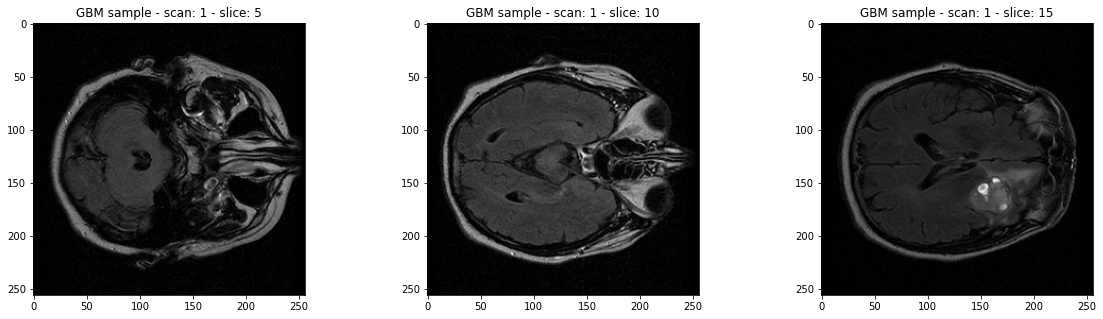

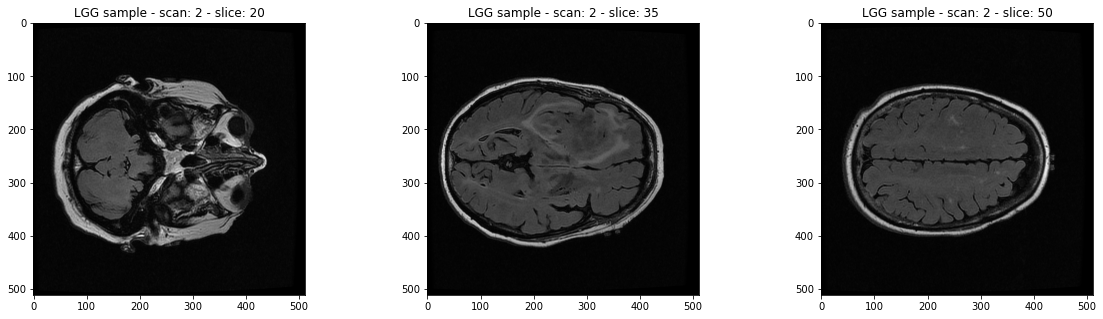

In [15]:
num_scan = 1
sample_gbm_array = nib.load(gbm_nii_paths[num_scan]).get_fdata()
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sample_slices = [5, 10, 15]
for i in range(3):
    axes[i].imshow(sample_gbm_array[:, :, sample_slices[i]], cmap='gray')
    axes[i].set_title(f'GBM sample - scan: {num_scan} - slice: {sample_slices[i]}')

num_scan = 2
sample_lgg_array = nib.load(lgg_nii_paths[num_scan]).get_fdata()
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sample_slices = [20, 35, 50]
for i in range(3):
    axes[i].imshow(sample_lgg_array[:, :, sample_slices[i]], cmap='gray')
    axes[i].set_title(f'LGG sample - scan: {num_scan} - slice: {sample_slices[i]}')

### Part 3 - Pre-processing

First, let's explore the volume dimension variation among our scans:

Text(0.5, 1.0, 'Volume Z dimension - LGG scans')

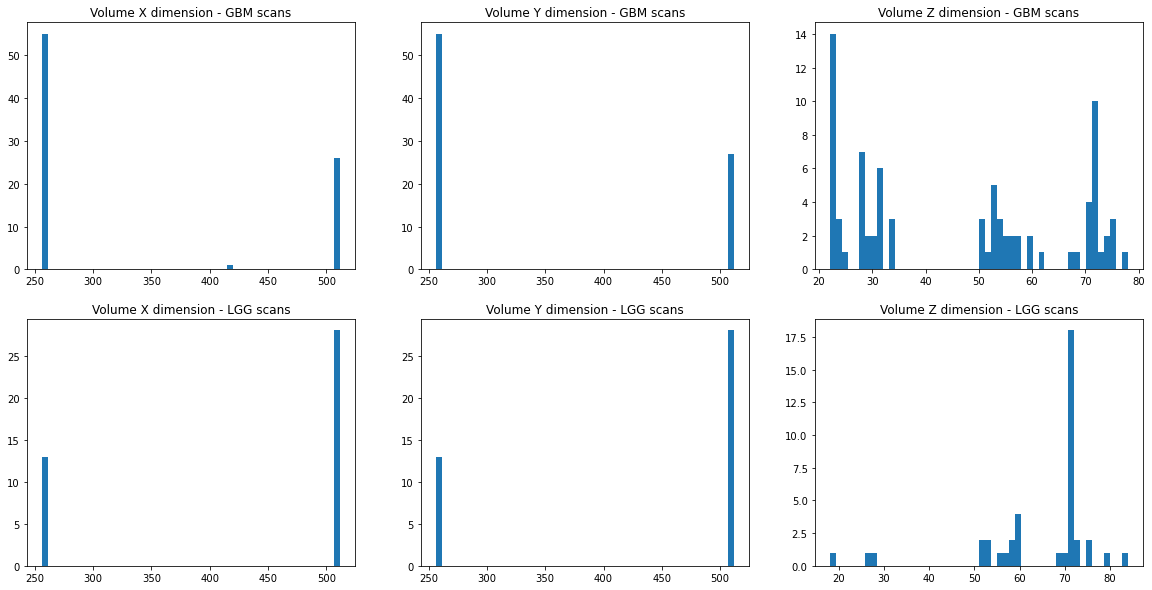

In [14]:
gbm_volume_dimensions = []
for nii_path in gbm_nii_paths:
    nii_header = nib.load(nii_path).header
    gbm_volume_dimensions.append(nii_header['dim'][1:4])
lgg_volume_dimensions = []
for nii_path in lgg_nii_paths:
    nii_header = nib.load(nii_path).header
    lgg_volume_dimensions.append(nii_header['dim'][1:4])
    
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes[0, 0].hist([x[0] for x in gbm_volume_dimensions], bins=50);
axes[0, 1].hist([x[1] for x in gbm_volume_dimensions], bins=50);
axes[0, 2].hist([x[2] for x in gbm_volume_dimensions], bins=50);
axes[1, 0].hist([x[0] for x in lgg_volume_dimensions], bins=50);
axes[1, 1].hist([x[1] for x in lgg_volume_dimensions], bins=50);
axes[1, 2].hist([x[2] for x in lgg_volume_dimensions], bins=50);
axes[0, 0].set_title('Volume X dimension - GBM scans')
axes[0, 1].set_title('Volume Y dimension - GBM scans')
axes[0, 2].set_title('Volume Z dimension - GBM scans')
axes[1, 0].set_title('Volume X dimension - LGG scans')
axes[1, 1].set_title('Volume Y dimension - LGG scans')
axes[1, 2].set_title('Volume Z dimension - LGG scans')

It seems that some of our scans are 256 * 256, while others are 512 * 512. Also, we have a lot of variation in the numner of axial slices we got in different scans.  
Let's also plot the variation of pixel dimension between scans.

Text(0.5, 1.0, 'Pixel Dimension (Z) - LGG scans')

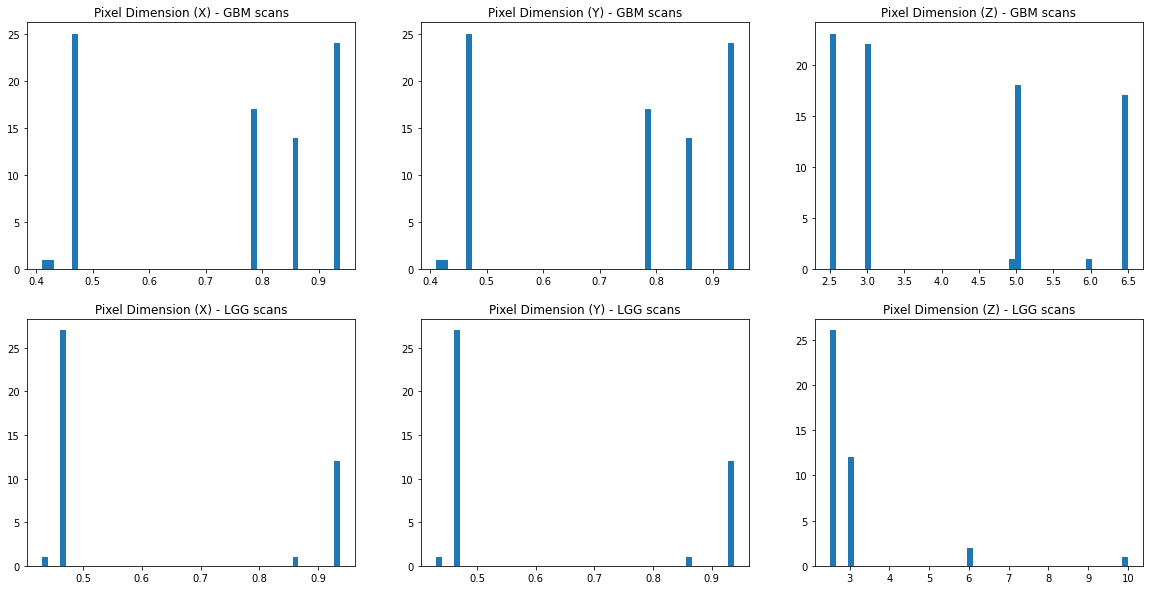

In [15]:
gbm_pixdims = []
for nii_path in gbm_nii_paths:
    nii_header = nib.load(nii_path).header
    gbm_pixdims.append(nii_header['pixdim'][1:4])
lgg_pixdims = []
for nii_path in lgg_nii_paths:
    nii_header = nib.load(nii_path).header
    lgg_pixdims.append(nii_header['pixdim'][1:4])
    
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes[0, 0].hist([x[0] for x in gbm_pixdims], bins=50);
axes[0, 1].hist([x[1] for x in gbm_pixdims], bins=50);
axes[0, 2].hist([x[2] for x in gbm_pixdims], bins=50);
axes[1, 0].hist([x[0] for x in lgg_pixdims], bins=50);
axes[1, 1].hist([x[1] for x in lgg_pixdims], bins=50);
axes[1, 2].hist([x[2] for x in lgg_pixdims], bins=50);
axes[0, 0].set_title('Pixel Dimension (X) - GBM scans')
axes[0, 1].set_title('Pixel Dimension (Y) - GBM scans')
axes[0, 2].set_title('Pixel Dimension (Z) - GBM scans')
axes[1, 0].set_title('Pixel Dimension (X) - LGG scans')
axes[1, 1].set_title('Pixel Dimension (Y) - LGG scans')
axes[1, 2].set_title('Pixel Dimension (Z) - LGG scans')

Now we create some transformations usin MONAI to prepare our scans for training. For doing so, we resample all our scans to a pixel dimension of (1, 1, 3) and resize them to the shape (128, 128, 128). The Z dimension will be padded by zero.

In [45]:
train_transforms = Compose(
    [
        LoadImaged(keys=["img"]),
        AddChanneld(keys=["img"]),
        Spacingd(keys=["img"], pixdim=(1., 1., 3.)),
        ScaleIntensityd(keys=["img"]),
        SpatialPadd(keys=["img"], spatial_size=128),
        Resized(keys=["img"], spatial_size=(128, 128, 128)),
        RandRotate90d(keys=["img"], prob=0.8, spatial_axes=[0, 1]),
        ToTensord(keys=["img"])
    ]

)

val_transforms = Compose(
    [
        LoadImaged(keys=["img"]),
        AddChanneld(keys=["img"]),
        Spacingd(keys=["img"], pixdim=(1., 1., 3.)),
        ScaleIntensityd(keys=["img"]),
        SpatialPadd(keys=["img"], spatial_size=128),
        Resized(keys=["img"], spatial_size=(128, 128, 128)),
        ToTensord(keys=["img"])
    ]

)

torch.Size([1, 128, 128, 128])


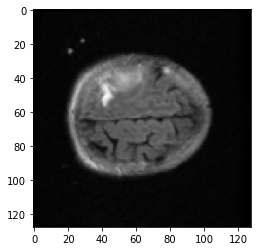

In [59]:
## Checking our transforms with one sample scan:

test_dict = {'img':gbm_nii_paths[0]}
sample_img = train_transforms(test_dict)
print(sample_img['img'].shape)
plt.imshow(sample_img['img'][0, :, :, 80], cmap='gray')

### Part 4 - Training

Here we train a sample 3D network to differentiate LGG and GBM lesions from each other. This is a routine training pipeline, mostly adopted from one of the MONAI tutorials: https://github.com/Project-MONAI/tutorials/blob/master/3d_classification/torch/densenet_training_dict.py

In [60]:
#Splitting the data

valid_gbm_paths = gbm_nii_paths[:len(gbm_nii_paths)//5]
train_gbm_paths = gbm_nii_paths[len(gbm_nii_paths)//5:]
valid_lgg_paths = lgg_nii_paths[:len(lgg_nii_paths)//5]
train_lgg_paths = lgg_nii_paths[len(lgg_nii_paths)//5:]

train_paths = train_gbm_paths + train_lgg_paths*2 # over-sampling the LGG lesions
valid_paths = valid_gbm_paths + valid_lgg_paths*2 # over-sampling the LGG lesions
train_labels = np.array([1 for i in range(len(train_gbm_paths))] + [0 for i in range(len(train_lgg_paths))]*2, dtype=np.int64)
valid_labels = np.array([1 for i in range(len(valid_gbm_paths))] + [0 for i in range(len(valid_lgg_paths))]*2, dtype=np.int64)

train_files = [{"img": img, "label": label} for img, label in zip(train_paths, train_labels)]
valid_files = [{"img": img, "label": label} for img, label in zip(valid_paths, valid_labels)]

In [80]:
act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=2)

# Creating a training data loader
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())

# Creating a validation data loader
valid_ds = monai.data.Dataset(data=valid_files, transform=val_transforms)
valid_loader = DataLoader(valid_ds, batch_size=2, num_workers=4, pin_memory=torch.cuda.is_available())

# Creating DenseNet121, CrossEntropyLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 3e-5)

In [67]:
# Checking the datasetsL
train_check_data = monai.utils.misc.first(train_loader)
valid_check_data = monai.utils.misc.first(valid_loader)

print(train_check_data["img"].shape, train_check_data["label"])
print(valid_check_data["img"].shape, valid_check_data["label"])

torch.Size([2, 1, 128, 128, 128]) tensor([1, 1])
torch.Size([2, 1, 128, 128, 128]) tensor([1, 1])


In [70]:
# Creating folders to save the best model and tensorboard logs:

os.mkdir('Model')
os.mkdir('Tensorboard_logs')

In [83]:
# Starting a typical PyTorch training
training_epochs = 10
train_epoch_len = len(train_ds) // train_loader.batch_size
valid_epoch_len = len(valid_ds) // valid_loader.batch_size

valid_interval = 1
best_metric = -1
best_metric_epoch = -1
train_loss_list = []
valid_loss_list = []
writer = SummaryWriter(log_dir='Tensorboard_logs')

for epoch in range(training_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{training_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    time.sleep(1)
    with tqdm(train_loader) as train_pbar:
        for batch_data in train_pbar:
            step += 1
            inputs, labels = batch_data["img"].to(device), batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            train_pbar.set_postfix({'loss': round(loss.item(), 2)})
            writer.add_scalar("train_loss", loss.item(), train_epoch_len * epoch + step)
        epoch_loss /= step
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        train_loss_list.append(epoch_loss)

    if (epoch + 1) % valid_interval == 0:
        model.eval()
        time.sleep(1)
        valid_step = 0
        valid_epoch_loss = 0
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for valid_data in valid_loader:
                valid_step += 1
                valid_images, valid_labels = valid_data["img"].to(device), valid_data["label"].to(device)
                valid_outputs = model(valid_images)
                valid_loss = loss_function(valid_outputs, valid_labels)
                valid_epoch_loss += valid_loss.item()
                y_pred = torch.cat([y_pred, valid_outputs], dim=0)
                y = torch.cat([y, valid_labels], dim=0)
                writer.add_scalar("valid_loss", valid_loss.item(), valid_epoch_len * epoch + valid_step)
            valid_epoch_loss /= valid_step
            valid_loss_list.append(valid_epoch_loss)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            y_onehot = to_onehot(y)
            y_pred_act = act(y_pred)
            auc_metric = compute_roc_auc(y_pred_act, y_onehot)
            del y_pred_act, y_onehot
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), f"Model/best_metric_model_classification3d_dict.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current accuracy: {:.4f} current AUC: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                    epoch + 1, acc_metric, auc_metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)
print(f"\ntrain completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/10


100%|██████████| 66/66 [00:37<00:00,  1.76it/s, loss=0.37]


epoch 1 average loss: 0.5473
saved new best metric model
current epoch: 1 current accuracy: 0.8438 current AUC: 0.9375 best accuracy: 0.8438 at epoch 1
----------
epoch 2/10


100%|██████████| 66/66 [00:36<00:00,  1.78it/s, loss=0.1] 


epoch 2 average loss: 0.5221
current epoch: 2 current accuracy: 0.8438 current AUC: 0.9375 best accuracy: 0.8438 at epoch 1
----------
epoch 3/10


100%|██████████| 66/66 [00:38<00:00,  1.71it/s, loss=0.31]


epoch 3 average loss: 0.5322
current epoch: 3 current accuracy: 0.8125 current AUC: 0.9688 best accuracy: 0.8438 at epoch 1
----------
epoch 4/10


100%|██████████| 66/66 [00:37<00:00,  1.76it/s, loss=0.53]


epoch 4 average loss: 0.4778
current epoch: 4 current accuracy: 0.8125 current AUC: 0.9531 best accuracy: 0.8438 at epoch 1
----------
epoch 5/10


100%|██████████| 66/66 [00:38<00:00,  1.73it/s, loss=0.52]


epoch 5 average loss: 0.5385
current epoch: 5 current accuracy: 0.8125 current AUC: 0.9375 best accuracy: 0.8438 at epoch 1
----------
epoch 6/10


100%|██████████| 66/66 [00:37<00:00,  1.75it/s, loss=0.58]


epoch 6 average loss: 0.4764
current epoch: 6 current accuracy: 0.5000 current AUC: 0.8359 best accuracy: 0.8438 at epoch 1
----------
epoch 7/10


100%|██████████| 66/66 [00:37<00:00,  1.74it/s, loss=0.55]


epoch 7 average loss: 0.4613
saved new best metric model
current epoch: 7 current accuracy: 0.9375 current AUC: 0.9531 best accuracy: 0.9375 at epoch 7
----------
epoch 8/10


100%|██████████| 66/66 [00:38<00:00,  1.72it/s, loss=0.15]


epoch 8 average loss: 0.4608
current epoch: 8 current accuracy: 0.9375 current AUC: 0.9844 best accuracy: 0.9375 at epoch 7
----------
epoch 9/10


100%|██████████| 66/66 [00:37<00:00,  1.75it/s, loss=0.41]


epoch 9 average loss: 0.3977
current epoch: 9 current accuracy: 0.9375 current AUC: 0.9688 best accuracy: 0.9375 at epoch 7
----------
epoch 10/10


100%|██████████| 66/66 [00:38<00:00,  1.71it/s, loss=0.36]


epoch 10 average loss: 0.4135
current epoch: 10 current accuracy: 0.6250 current AUC: 0.7500 best accuracy: 0.9375 at epoch 7

train completed, best_metric: 0.9375 at epoch: 7


This brings us to the end of our notebook. From this point on, you can use the model for inference on a bucket's data,  download the model to your local PC, or monitor the training process via tensorboard.  
Hope you found this notebook useful!